In [21]:
import transformers
print(transformers.__version__)


4.51.3


In [3]:
from transformers import TrainingArguments
print(TrainingArguments.__module__)


transformers.training_args


# ✅ Step 1: Import Required Libraries

In [4]:
import pandas as pd
import numpy as np
import os
from datasets import Dataset, DatasetDict, ClassLabel
#from evaluate import load_metric
from transformers import AutoTokenizer, AutoModelForTokenClassification, DataCollatorForTokenClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
import random

# ✅ Step 2: Load the Dataset

In [5]:
raw_df = pd.read_csv('/content/ner_dataset.csv', encoding='latin1')
raw_df = raw_df.fillna(method='ffill')
raw_df.head()


<ipython-input-5-d967cc6774c9>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  raw_df = raw_df.fillna(method='ffill')


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


# ✅ Step 3: Preprocess into Sentence Chunks

In [6]:
data = []
sentence = []
for i, row in raw_df.iterrows():
    word, tag = row['Word'], row['Tag']
    if pd.isna(row['Sentence #']) and word == '.':
        sentence.append((word, tag))
        data.append(sentence)
        sentence = []
    else:
        sentence.append((word, tag))
        if i + 1 < len(raw_df) and raw_df.iloc[i + 1]['Sentence #'] != row['Sentence #']:
            data.append(sentence)
            sentence = []

# ✅ Step 4: Format for HuggingFace Dataset



In [7]:
sentences = [[token for token, label in sentence] for sentence in data]
labels = [[label for token, label in sentence] for sentence in data]
unique_labels = list(set(label for doc in labels for label in doc))
unique_labels.sort()
label2id = {label: i for i, label in enumerate(unique_labels)}
id2label = {i: label for label, i in label2id.items()}

label_ids = [[label2id[label] for label in doc] for doc in labels]


# ✅ Step 5: Create Dataset Object

In [8]:
df_data = {'tokens': sentences, 'ner_tags': label_ids}
dataset = Dataset.from_dict(df_data)
dataset = dataset.train_test_split(test_size=0.2, seed=42)
dataset_dict = DatasetDict({"train": dataset['train'], "test": dataset['test']})

# ✅ Step 6: Load Tokenizer and Model

In [9]:
model_checkpoint = "bert-base-cased"  # Generic BERT base model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(unique_labels),
    id2label=id2label,
    label2id=label2id
)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# ✅ Step 7: Tokenization with Alignment


In [10]:
def tokenize_and_align_labels(example):
    tokenized_inputs = tokenizer(example["tokens"], truncation=True, is_split_into_words=True)
    labels = []
    word_ids = tokenized_inputs.word_ids()
    previous_word_idx = None
    for word_idx in word_ids:
        if word_idx is None:
            labels.append(-100)
        elif word_idx != previous_word_idx:
            labels.append(example["ner_tags"][word_idx])
        else:
            labels.append(-100)
        previous_word_idx = word_idx
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

tokenized_datasets = dataset_dict.map(tokenize_and_align_labels, batched=False)


Map:   0%|          | 0/15865 [00:00<?, ? examples/s]

Map:   0%|          | 0/3967 [00:00<?, ? examples/s]

# ✅ Step 8: Define Metrics and Training Arguments


In [23]:

import evaluate



metric = evaluate.load("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [id2label[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

args = TrainingArguments(
    output_dir="ner-finetuned-bert",
    do_train=True,
    do_eval=True,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10
)


data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)


# ✅ Step 9: Train the Model

In [24]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


trainer.train()

<ipython-input-24-46296f063cb6>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: toqai1368 (toqai1368-benha-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
10,2.079200
20,0.854900
30,0.687100
40,0.456200
50,0.384400
60,0.324500
70,0.264500
80,0.211900
90,0.203700
100,0.203300


TrainOutput(global_step=2976, training_loss=0.11100230214776852, metrics={'train_runtime': 640.488, 'train_samples_per_second': 74.311, 'train_steps_per_second': 4.646, 'total_flos': 1108788085686102.0, 'train_loss': 0.11100230214776852, 'epoch': 3.0})

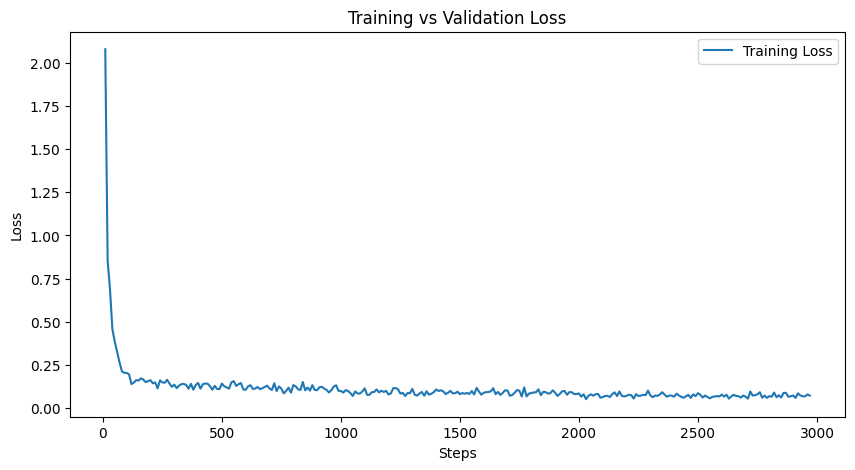

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Load training logs (stored in log history)
logs = trainer.state.log_history
df = pd.DataFrame(logs)

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(df["step"], df["loss"], label="Training Loss")
if "eval_loss" in df.columns:
    plt.plot(df["step"], df["eval_loss"], label="Validation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

# Plot F1 Score if available
if "eval_f1" in df.columns:
    plt.figure(figsize=(10, 5))
    plt.plot(df["step"], df["eval_f1"], label="F1 Score", color='green')
    plt.xlabel("Steps")
    plt.ylabel("F1 Score")
    plt.title("F1 Score During Training")
    plt.legend()
    plt.show()


# ✅ Step 10: Save Model

In [25]:
trainer.save_model("/kaggle/ner_finetuned_model")

# ✅ Step 12: Make Predictions on New Text


In [26]:
from transformers import pipeline
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")
sample_text = "Barack Obama visited New York City in 2023."
predictions = ner_pipeline(sample_text)
for entity in predictions:
    print(f"{entity['word']} -> {entity['entity_group']} ({entity['score']:.2f})")


Device set to use cuda:0


Barack Obama -> per (0.95)
New York City -> geo (0.96)
2023 -> tim (0.98)


In [28]:
from IPython.display import display, HTML

def highlight_ner(text, entities):
    for entity in sorted(entities, key=lambda x: x['start'], reverse=True):
        text = (
            text[:entity['start']] +
            f"<mark style='background-color:lightblue;'>{text[entity['start']:entity['end']]} <sub>({entity['entity_group']})</sub></mark>" +
            text[entity['end']:]
        )
    return text

# Use existing predictions
html_output = highlight_ner(sample_text, predictions)
display(HTML(html_output))
